# LSTM Sequence Classification
Reference: https://towardsdatascience.com/word-bags-vs-word-sequences-for-text-classification-e0222c21d2ec

Import Libraries:

In [9]:
import numpy as np
import os
import time
from datetime import datetime
import pandas as pd
import json
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import random as rn
import keras
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

startTime = time.time()
print("Tensor Flow Version: ",tf.__version__)

Tensor Flow Version:  2.2.0-rc2


In [10]:
#All this for reproducibility
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(112)

In [11]:
# Build the corpus and sequences
labelToName = { 0 : 'Rejected', 1 : 'Allowed' }
namesInLabelOrder = ['Rejected', 'Allowed']
os.chdir('D:\\PhD\\Dataset')
df=pd.read_csv('CriminalBailApplication.csv')
X=df.text.tolist()
labels=df.loc[:,['label']]


def preprocess(temp):
    temp=re.sub("\s\s+"," ",temp)    #Replacing multiple spaces with one
    temp=temp.replace(u'\xa0', ' ').encode('utf-8')  #Replacing non-breaking space    
    temp=temp.decode().split(' ')    #Converting a string into list of words seperated by space charcter
    return temp

#print(X[1])
X = [preprocess(t) for t in X]  
#print("\n\n\n After Preprocess:\n\n",X[1])


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1).split(X, labels)
train_indices, test_indices = next(sss)


def seqlengths(l):
    if isinstance(l,list):
        yield len(l)
        for y in l:
            yield from seqlengths(y)

maxsequenceLength=max(seqlengths(X))
print("Max sequence length:",maxsequenceLength)


Max sequence length: 1502


In [12]:
# Encode the documents
kTokenizer = keras.preprocessing.text.Tokenizer() 
kTokenizer.fit_on_texts(X)

#print("Tokanizer:\n",kTokenizer.word_index)

#print("Before Encoding:\n",X[230])
Xencoded = np.array([np.array(xi) for xi in kTokenizer.texts_to_sequences(X)])                
#print("After Encoding:\n",Xencoded[230])

print("Shape Before Padding:",np.shape(Xencoded[22]))
Xencoded=keras.preprocessing.sequence.pad_sequences(Xencoded, maxlen=maxsequenceLength, truncating='post')
print("\nShape After Padding:",np.shape(Xencoded[22]))

labels = np.array(labels)

nWords=len(kTokenizer.word_index)
print("\n nWords:",nWords)

Shape Before Padding: (782,)

Shape After Padding: (1502,)

 nWords: 8793


In [13]:
# Build the LSTM model
def getModel():
    units1, units2 = int (nWords/4), int (nWords/8)
    model = keras.models.Sequential()
    model.add(keras.layers.embeddings.Embedding(input_dim = nWords+1,output_dim=units1,input_length=maxsequenceLength, trainable=True))               
    model.add(keras.layers.LSTM(units = units2, return_sequences =False))                              
    model.add(keras.layers.Dense(len(labelToName), activation ='softmax'))                           
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
    return model

In [33]:
train_x = Xencoded[train_indices]
test_x = Xencoded[test_indices]
train_labels = keras.utils.to_categorical(labels[train_indices], len(labelToName))
test_labels = keras.utils.to_categorical(labels[test_indices], len(labelToName))

In [ ]:
# Train and test over multiple train/validation sets
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=False)                         
sss2 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1).split(train_x, train_labels)          
results={}
for i in range(2):
    train_indices_2, val_indices = next(sss2)
    model = getModel()
    model.summary()
    history=model.fit(x=train_x[train_indices_2], y=train_labels[train_indices_2], epochs=50, batch_size=32, shuffle=True, validation_data = (train_x[val_indices], train_labels[val_indices]), verbose=2, callbacks=[early_stop], use_multiprocessing=True)
    test_loss, test_accuracy = model.evaluate(test_x, test_labels, verbose=2)                                
    print ("\ntest_loss:",test_loss, "\ntest_accuracy:",test_accuracy)
    predicted = model.predict(test_x, verbose=2)
    predicted_labels = predicted.argmax(axis=1)        
    print ("\n\nConfusion Matrix:\n",confusion_matrix(labels[test_indices], predicted_labels))
    print ("\n\nClassification Report:\n\n",classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder))
    result={}
    result['confusion_matrix'] = confusion_matrix(labels[test_indices], predicted_labels).tolist()
    result['classification_report'] = classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder, output_dict=True)
    results[i] = result
os.chdir('D:\\PhD\\Dataset\\Results')
filename = 'LSTM-'+time.strftime("%d-%m-%Y-%H-%M-%S")+'.json'
f = open (filename,'w')
out = json.dumps(results, ensure_ascii=True)
f.write(out)
f.close()

endTime = time.time()
hours, rem = divmod(endTime-startTime, 3600)
minutes, seconds = divmod(rem, 60)
print("\n\nTotal time taken: ")
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1502, 2198)        19329212  
_________________________________________________________________
lstm_2 (LSTM)                (None, 1099)              14498008  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2200      
Total params: 33,829,420
Trainable params: 33,829,420
Non-trainable params: 0
_________________________________________________________________


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 210 samples, validate on 53 samples
Epoch 1/50
 - 835s - loss: 0.6461 - acc: 0.7762 - val_loss: 0.4989 - val_acc: 0.7925
Epoch 2/50
 - 839s - loss: 0.3225 - acc: 0.8810 - val_loss: 0.3568 - val_acc: 0.8302
Epoch 3/50
 - 829s - loss: 0.0906 - acc: 0.9714 - val_loss: 0.4284 - val_acc: 0.8868
Epoch 4/50
 - 835s - loss: 0.0221 - acc: 0.9857 - val_loss: 0.3648 - val_acc: 0.8491
Epoch 5/50
 - 836s - loss: 0.0231 - acc: 0.9952 - val_loss: 0.2692 - val_acc: 0.8679
Epoch 6/50
 - 839s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.2728 - val_acc: 0.8679
Epoch 7/50
 - 841s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2581 - val_acc: 0.8679
Epoch 8/50
 - 843s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2549 - val_acc: 0.8679
Epoch 9/50
 - 870s - loss: 5.9444e-04 - acc: 1.0000 - val_loss: 0.2746 - val_acc: 0.8679
Epoch 10/50
 - 975s - loss: 2.8626e-04 - acc: 1.0000 - val_loss: 0.3184 - val_acc: 0.8868
Epoch 11/50


In [47]:
result={}
resluts={}
print(confusion_matrix(labels[test_indices], predicted_labels))
print(classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder))

result['confusion_matrix'] = confusion_matrix(labels[test_indices], predicted_labels).tolist()
result['classification_report'] = classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder, output_dict=True)
results[0] = result

os.chdir('D:\\PhD\\Dataset\\Results')
filename = 'LSTM-'+time.strftime("%d-%m-%Y-%H-%M-%S")+'.json'
f = open (filename,'w')
out = json.dumps(results, ensure_ascii=True, indent=4)
f.write(out)
f.close()

[[48  3]
 [ 3 12]]
              precision    recall  f1-score   support

    Rejected     0.9412    0.9412    0.9412        51
     Allowed     0.8000    0.8000    0.8000        15

    accuracy                         0.9091        66
   macro avg     0.8706    0.8706    0.8706        66
weighted avg     0.9091    0.9091    0.9091        66



In [18]:
print(len(history.history['acc']))
print(len(history.history['val_acc']))
print(len(history.history['loss']))
print(len(history.history['val_loss']))
print(len(history.history['acc']))

8
8
8
8


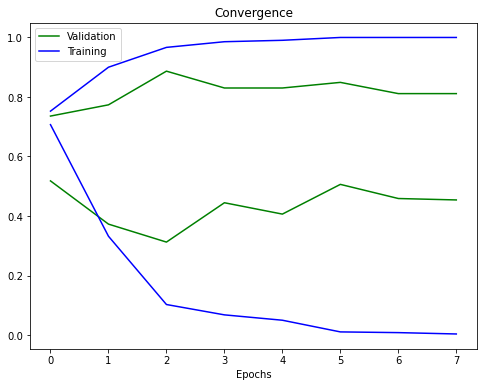

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1, 1, 1)

loss_train = history.history['loss']
loss_val = history.history['val_loss']

acc_train = history.history['acc']
acc_val = history.history['val_acc']

epochs = range(0,len(history.history['val_acc']))

subplot.plot(epochs,acc_val,color='g', label='Validation')
subplot.plot(epochs,loss_val,color='g')
subplot.plot(epochs,acc_train,color='b')
subplot.plot(epochs,loss_train,color='b', label='Training')

plt.title('Convergence')
plt.xlabel('Epochs')
#subplot.legend(loc='upper left', prop={'size': 9})
plt.legend()
plt.show()

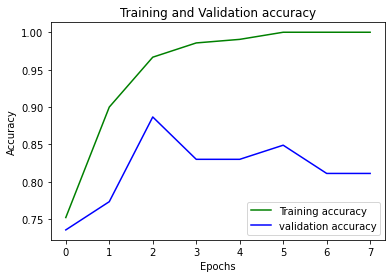

In [30]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(0,len(history.history['val_acc']))
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

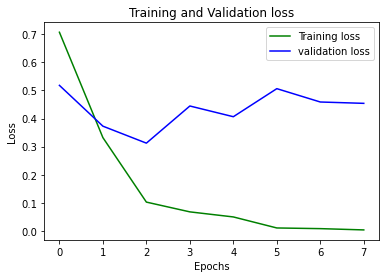

In [31]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,len(history.history['val_loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()